# Water Change


In [5]:
# jupyteronly
%matplotlib inline
import datacube
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

from matplotlib.cm import RdYlGn, Greens

### Import required modules

In [2]:
import numpy as np
import xarray as xr
from pyproj import Proj, transform

from datacube.storage import masking
from datacube_utilities.createAOI import create_lat_lon
from datacube_utilities.dc_water_classifier import wofs_classify
from datacube_utilities.interactive_maps import display_map
from datacube_utilities.dc_utilities import write_geotiff_from_xr
from datacube.utils.cog import write_cog


import dask
from dask.distributed import Client

client = Client('dask-scheduler.dask.svc.cluster.local:8786')

client.get_versions(check=True)
client

/opt/conda/envs/cubeenv/lib/python3.6/site-packages/datacube/storage/masking.py:4: DeprecationWarning: datacube.storage.masking has moved to datacube.utils.masking
  category=DeprecationWarning)


Client Scheduler: tcp://dask-scheduler.dask.svc.cluster.local:8786 Dashboard: http://dask-scheduler.dask.svc.cluster.local:8787/status,Cluster Workers: 5 Cores: 15 Memory: 100.00 GB


## Initialise

In [3]:
# jupyteronly
dc = datacube.Datacube(app='water-change')

## Set up datacube query.
This includes options for crs, a groupby for overlapping datasets, a time range, and a spatial extent. 

In [4]:
# parameters

#area of interest: load in as wkt
#parameter display_name="Area of Interest" description="The area for which the product is required." datatype="wkt",
aoi_wkt = "POLYGON ((177.62557983398438 -17.590848708679893, 177.77372360229492 -17.590848708679893, 177.77372360229492 -17.488875828028657, 177.62557983398438 -17.488875828028657, 177.62557983398438 -17.590848708679893))"

#set start and end dates for time period of interest
#parameter display_name="Baseline Start Date" description='Start of the baseline time period window' datatype="date"
baseline_time_start = '2015-3-1'
#parameter display_name="Baseline End Date" description='End of the baseline time period window' datatype="date"
baseline_time_end = '2015-9-1'

#set start and end dates for time period of interest
#parameter display_name="Analysis Start Date" description='Start of the analysis time period window' datatype="date"
analysis_time_start = '2016-3-1'
#parameter display_name="Analysis End Date" description='End of the analysis time period window' datatype="date"
analysis_time_end = '2016-9-1'

#set resolution
#parameter display_name="Resolution" description="size of pixes" datatype="int"
res = (30)

#choose sensor
#parameter display_name="Baseline Sensor" description="Satellite to use for baseline time period." datatype="multi" options=["SENTINEL_2", "LANDSAT_4", "LANDSAT_5", "LANDSAT_7", "LANDSAT_8"],
baseline_platform = ["LANDSAT_8"]

#choose sensor
#parameter display_name="Sensor" description="Satellite to use for analysis time period." datatype="multi" options=["SENTINEL_2", "LANDSAT_4", "LANDSAT_5", "LANDSAT_7", "LANDSAT_8", "SENTINEL_2"],
analysis_platform = ["LANDSAT_8"]

#parameter display_name="Coordinate Reference System" description="The EPSG code for the CRS, for Fiji this will be 3460." datatype="string" options=["3460", "3832"],
crs = "3460"

#this parameter should be restricted to between 1 and 100, should not be valid for landsat4 and landsat5
#parameter display_name="Percentage Confidence" description="The level of confidence acceptable for an individual pixel, recommended to start with 5%" datatype="int"
confidenceLevel = (5)

#parameter which determines what water threshold we accept as being water. Restrict to be between 0 and 1. 
#parameter display_name="Water Threshold" description="The value for how strinct water mask should be, value of 0 equates to always land, value of 1 always water" datatype="float" 
waterThresh = 0.3


### Reformat Parameters

In [8]:
#get latitude and longitude
lat_extents, lon_extents = create_lat_lon(aoi_wkt)

In [9]:
# jupyteronly
## The code below renders a map that can be used to orient yourself with the region.
display_map(latitude = lat_extents, longitude = lon_extents)

In [10]:
#reprojection of AOI into input CRS and reformat
inProj  = Proj("+init=EPSG:4326")
outProj = Proj("+init=EPSG:"+crs)
min_lat, max_lat = (lat_extents) 
min_lon, max_lon = (lon_extents)
x_A, y_A = transform(inProj, outProj, min_lon, min_lat)
x_B, y_B = transform(inProj, outProj, max_lon, max_lat)
lat_range = (y_A, y_B)
lon_range = (x_A, x_B)
print(lat_range)
print(lon_range)

/opt/conda/envs/cubeenv/lib/python3.6/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)
/opt/conda/envs/cubeenv/lib/python3.6/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)
/opt/conda/envs/cubeenv/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  


(3934260.914984402, 3945633.577378467)
(1880642.0275783802, 1896308.818778341)


/opt/conda/envs/cubeenv/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  import sys


In [8]:
productDict = {"SENTINEL_2":"s2_water_mlclassification", 
    "SENTINEL_1": "s1_water_mlclassification",
    "LANDSAT_8": "ls8_water_mlclassification",
    "LANDSAT_7": "ls7_water_mlclassification",
    "LANDSAT_5": "ls5_water_classification",
    "LANDSAT_4": "ls4_water_classification",
}

def getWaterProduct(platform):
    return [productDict[i] for i in platform]



['ls8_water_mlclassification']
['ls8_water_mlclassification']


In [9]:
#get names of desired water products
baseline_water_product = getWaterProduct(baseline_platform)
print(baseline_water_product)

analysis_water_product = getWaterProduct(analysis_platform)
print(analysis_water_product)

['ls8_water_mlclassification']
['ls8_water_mlclassification']


In [10]:
#create resolution
resolution = (-res, res)

In [ ]:
dask_chunks = dict(
    time = 1,
    x = 2000,
    y = 2000
)

In [64]:
#time_range
#format dates
from datetime import datetime
def createDate(inputStart, inputEnd):
    start = datetime.strptime(inputStart, '%Y-%m-%d')
    end = datetime.strptime(inputEnd, '%Y-%m-%d')
    startDates = start.date()
    endDates = end.date()
    time_period = (startDates, endDates)
    return time_period
baseline_time_period = createDate(baseline_start_date, baseline_end_date)
analysis_time_period = createDate(analysis_start_date, analysis_end_date)


## Load Data 

In [80]:
#generic for load query
query = {
    'longitude': lon_range,
    'latitude': lat_range,
    'output_crs': "EPSG:"+crs,
    'resolution': resolution,
    'dask_chunks': dask_chunks,
    'crs': "EPSG:"+crs
}

In [83]:
#function to check if datasets are empty
def is_dataset_empty(ds:xr.Dataset) -> bool:
    checks_for_empty = [
                        lambda x: len(x.dims) == 0,      #Dataset has no dimensions
                        lambda x: len(x.data_vars) == 0  #Dataset no variables 
                       ]
    for f in checks_for_empty:
         if f(ds) == True:
                return True
    return False

### Load in water masks

In [ ]:
#go through dataset list and load those which have data based on the query. 
def loadWaterMask(productInput, time_period):
    if productInput in ["s2_water_mlclassification", "ls8_water_mlclassification", "ls7_water_ml_classification"]:
        water_scenes = dc.load(product=productInput,
              measurements = ["watermask", "waterprob"],
                               'time': time_period,
               **query)
        if is_dataset_empty(water_scenes):
            print(productInput, 'is empty')
        #change clouds to no data value
        else:
            water_classes = water_scenes.where(water_scenes >= 0)
            good_quality_water = (
               (water_scenes.watermask >= 0) & # no data
                (
                 (water_scenes.waterprob <= confidenceLevel) |
                    (water_scenes.waterprob >= 100-confidenceLevel)
                )
                )
            water_classes = water_scenes.where(good_quality_water)
            water_classes['waterprob'] = (100-water_classes['waterprob']) # assign nodata vals consistent w/ other prods
            product_data = water_classes
    elif productInput in ["ls5_water_classification", "ls4_water_classification"]:
        water_scenes = dc.load(product=productInput,
                               measurements = ["water"],
                               'time': baseline_time_period,
                                   **query)
        if is_dataset_empty(water_scenes):
            print(productInput, 'is empty')
        else:
            water_classes1 = water_scenes.where(water_scenes != -9999)
            water_classes1['watermask'] = water_classes1['water']
            water_classes = water_classes1.drop(['water'])
            product_data = water_classes
    else:
        print('invalid platform')
    return product_data



In [ ]:
waterclass_baseline = loadWaterMask(baseline_water_product, baseline_time_period)
wc_baseline = xr.concat(waterclass_baseline, dim='time').sortby('time')
wc_baseline.nbytes/1000000000, wc_baseline

In [ ]:
waterclass_analysis = loadWaterMask(analysis_water_product, analysis_time_period)
wc_analysis = xr.concat(waterclass_analysis, dim='time').sortby('time')
wc_analysis.nbytes/1000000000, wc_analysis

## Create mosaic of water mask

In [91]:
wc_baseline_mean = wc_baseline.watermask.mean(dim='time')
wc_baseline_mean 

<xarray.DataArray 'watermask' (y: 380, x: 523)>
dask.array<mean_agg-aggregate, shape=(380, 523), dtype=float64, chunksize=(380, 523), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 3.946e+06 3.946e+06 ... 3.934e+06 3.934e+06
  * x            (x) float64 1.881e+06 1.881e+06 ... 1.896e+06 1.896e+06
    spatial_ref  int32 3460

In [92]:
wc_analysis_mean = wc_analysis.watermask.mean(dim='time')
wc_analysis_mean

<xarray.DataArray 'watermask' (y: 380, x: 523)>
dask.array<mean_agg-aggregate, shape=(380, 523), dtype=float64, chunksize=(380, 523), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 3.946e+06 3.946e+06 ... 3.934e+06 3.934e+06
  * x            (x) float64 1.881e+06 1.881e+06 ... 1.896e+06 1.896e+06
    spatial_ref  int32 3460

In [117]:
#fig, ax = plt.subplots(figsize=(50,50))
#ax.imshow(wc_baseline_mean)

In [118]:
#fig, ax = plt.subplots(figsize=(50,50))
#ax.imshow(wc_analysis_mean)

In [ ]:
#water_pc = (landsat_resampled_prob*100).where((landsat_resampled_prob == False),-9999) # assign nodata vals consistent w/ other prods

### Make difference range product

In [12]:
###This is the second output we want.
difference_range = (wc_analysis_mean - wc_baseline_mean)

NameError: name 'wc_analysis_mean' is not defined

In [13]:
# jupyteronly
%%time
difference_range = difference_range.compute()
plt.figure(figsize = (8,8))
difference_range.plot(vmin=-1, vmax=1, cmap=RdYlGn)

UsageError: Line magic function `%%time` not found.


### Make threshold difference product

In [93]:
%%time
T0_nd_water = np.isnan(wc_baseline_mean)
wc_baseline_rc_int = wc_baseline_mean.where((wc_baseline_mean < waterThres) | (T0_nd_water == True), 1) # fix > prob to water
wc_baseline_rc = wc_baseline_rc_int.where((wc_baseline_rc_int >= waterThres) | (T0_nd_water == True), 0) # fix < prob to no water

CPU times: user 39.4 ms, sys: 0 ns, total: 39.4 ms
Wall time: 39 ms


In [94]:
%%time
T1_nd_water = np.isnan(wc_analysis_mean)
wc_analysis_rc_int = wc_analysis_mean.where((wc_analysis_mean < waterThres) | (T1_nd_water == True), 1) # fix > prob to water
wc_analysis_rc = wc_analysis_rc_int.where((wc_analysis_rc_int >= waterThres) | (T1_nd_water == True), 0) # fix < prob to no water

CPU times: user 44.8 ms, sys: 157 µs, total: 45 ms
Wall time: 123 ms


In [95]:
# jupyteronly
# plotting
%%time
# compute intermediary so we can plot it
wc_baseline_rc_comp = wc_baseline_rc.compute()
fig, ax = plt.subplots(figsize=(50,50))
ax.imshow(wc_baseline_rc_comp)

CPU times: user 8 s, sys: 5 s, total: 13 s
Wall time: 1min 39s


/opt/conda/envs/cubeenv/lib/python3.6/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/envs/cubeenv/lib/python3.6/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in less
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/envs/cubeenv/lib/python3.6/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in greater_equal
  return func(*(_execute_task(a, cache) for a in args))


In [15]:
# jupyteronly
%%time
# compute intermediary so we can plot it
wc_analysis_rc_comp = wc_analysis_rc.compute()
fig, ax = plt.subplots(figsize=(50,50))
ax.imshow(wc_analysis_rc_comp)

UsageError: Line magic function `%%time` not found.


In [101]:
### difference is one of the outputs we want.
difference = (wc_analysis_rc - wc_baseline_rc)

In [102]:
%%time
difference = difference.compute()

/opt/conda/envs/cubeenv/lib/python3.6/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


CPU times: user 16.1 s, sys: 11 s, total: 27.1 s
Wall time: 3min 55s


/opt/conda/envs/cubeenv/lib/python3.6/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in less
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/envs/cubeenv/lib/python3.6/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in greater_equal
  return func(*(_execute_task(a, cache) for a in args))


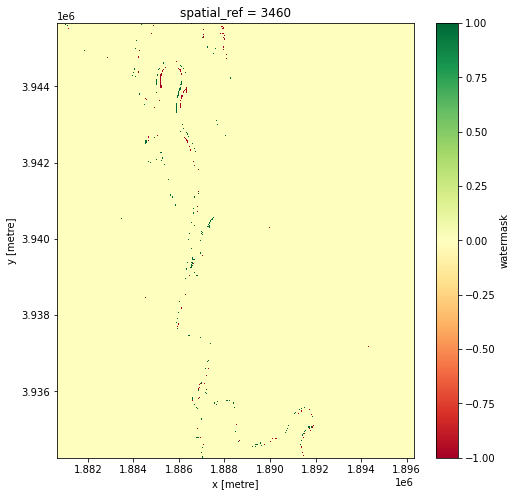

In [103]:
# jupyteronly
plt.figure(figsize = (8,8))
difference.plot(vmin=-1, vmax=1, cmap=RdYlGn)

### Export

In [ ]:
#export range product as cog
write_cog(geo_im=difference_range,
          fname='difference_range.tif',
          overwrite=True)

In [ ]:
#export threshold product as cog
write_cog(geo_im=difference_thres,
          fname='difference.tif',
          overwrite=True)

In [19]:
#export as tifs
#write_geotiff_from_xr('difference_range.tiff', difference_range, crs=output_projection, x_coord = 'x', y_coord = 'y')
#write_geotiff_from_xr('difference.tiff', difference, crs=output_projection, x_coord = 'x', y_coord = 'y')

In [18]:
#naming exports for ESRI to pick up
['difference_range.tif', 'difference_thres.tif' ]

['difference_range.tif', 'difference_thres.tif']

---